# French name transcription from handwriting using deep learning

Author: Carlos Domínguez Becerril

### Abstract

Handwriting optical character recognition (OCR) is the process of automatically extracting handwritten information from paper, scans and other low-quality digital documents. The intend of this project is to build a deep neural network that is able transcribe 400.000 handwritten names collected through charity projects to support disadvantaged children around the world.

#### Warning: The notebook takes around 3 hours to execute using a GPU and around 7GiB of RAM.

The dataset can be found in the Appen machine learning repository. 

https://appen.com/datasets/handwritten-name-transcription-from-an-image/

In order to make the notebook work download the dataset and create the next file system:

- dataset (folder)
    - train (folder)
        - images (folder) -> The training images folder.
        - training_metadata.csv (file) -> written_name_train_v2.csv file renamed.
    - test (folder)
        - images (folder) -> The testing images folder.
        - test_metadata.csv (file) -> written_name_test_v2.csv file renamed.
    - dev (folder)
        - images (folder) -> The VALIDATION images folder.
        - development_metadata.csv (file) -> written_name_validation_v2.csv file renamed.
 
 The parenthesis indicates wheter it is a file or a folder

### Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid, save_image
from torchvision import models
from torchsummary import summary

from tqdm.notebook import tqdm

import pandas as pd

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Preparing the dataset

#### Images and metadata paths

In [2]:
train_images = "./dataset/train/images/"
train_metadata = "./dataset/train/training_metadata.csv"
development_images = "./dataset/dev/images/"
development_metadata = "./dataset/dev/development_metadata.csv"
test_images = "./dataset/test/images/"
test_metadata = "./dataset/test/test_metadata.csv"

#### Global variables in order to train the model

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = 4
SHUFFLE = True
PIN_MEMORY = True
IMAGE_SIZE = (64, 256) # Height, width

### Visualizing the dataset

#### First check the format of the csv file 

In [4]:
csv = pd.read_csv(test_metadata)

In [5]:
csv.head()

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


#### Now we check a picture 

In [6]:
def show_example(img, name, open_file=False):
    print("Name: ", name)
    if open_file:
        img_file = mpimg.imread(img)
        plt.imshow(img_file)
    else:
        img_file = img
        plt.imshow(img_file.squeeze(), cmap="gray")


Name:  KEVIN


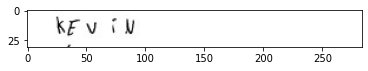

In [7]:
show_example(test_images + "TEST_0001.jpg", "KEVIN", True)

#### Check for missing values and retrieve information about the dataset

In [8]:
def missing_values(filename, name_info):
    csv = pd.read_csv(filename)
    missing_names = csv['IDENTITY'].isnull().sum() 
    missing_files = csv['FILENAME'].isnull().sum()
    length = len(csv)
    lower_case = csv['IDENTITY'].str.islower().sum()
    upper_case = csv['IDENTITY'].str.isupper().sum()
    incorrect_names = csv.index[~(csv['IDENTITY'].str.isupper() | csv['IDENTITY'].str.islower())]
    unique_names = csv['IDENTITY'].unique()
    unique_characters = set()
    longest_name = 0
    for name in unique_names:
        if not isinstance(name, str):
            continue
        longest_name = max(longest_name, len(name))
        for char in name:
            unique_characters.add(char)
    print("Checking", name_info)
    print("Length: {}".format(length, name))
    print("Missing names: {}".format(missing_names, name))
    print("Missing filenames: {}".format(missing_files, name))
    print("Names in lower case: ", lower_case)
    print("Names in upper case: ", upper_case)
    print("Incorrect names: ", len(incorrect_names)-missing_names)
    print("Number of different names: ", len(unique_names))
    print("Unique characters: ", unique_characters)
    print("Longest name: ", longest_name)
    print("")

In [9]:
missing_values(train_metadata, "train")
missing_values(development_metadata, "development")
missing_values(test_metadata, "test")

Checking train
Length: 330961
Missing names: 565
Missing filenames: 0
Names in lower case:  13
Names in upper case:  330366
Incorrect names:  17
Number of different names:  100540
Unique characters:  {'U', 'R', 'I', 'C', 'F', 'v', '`', 'K', 'N', 'D', 'f', 'n', 'B', '-', 'O', 'W', 'M', 'c', 'E', 'P', 'Y', 'r', 's', 'l', 'V', 'g', 'G', 'a', 'z', 'o', 'y', 'i', 'Q', 'p', 'e', 'H', 'J', 'T', 'Z', ' ', 'X', 'm', "'", 'b', 'A', 'u', 'L', 'S', 'h', 't'}
Longest name:  34

Checking development
Length: 41370
Missing names: 78
Missing filenames: 0
Names in lower case:  2
Names in upper case:  41290
Incorrect names:  0
Number of different names:  20228
Unique characters:  {'U', 'I', 'R', 'C', 'F', 'K', 'N', 'D', 'n', 'B', '-', 'O', 'W', 'M', 'E', 'P', 'Y', 'r', 'l', 's', 'V', 'g', 'G', 'a', 'o', 'i', 'Q', 'p', 'H', 'J', 'T', 'Z', ' ', 'X', "'", 'A', 'u', 'L', 'S', 't'}
Longest name:  21

Checking test
Length: 41370
Missing names: 70
Missing filenames: 0
Names in lower case:  2
Names in upper case

Problems found:

- There are missing names
- Some names are in upper case and others in lower case
- There are incorrect names

Decisions taken:

- Delete the examples with missing names from the dataset because it only happens a low number of times.
    - In training: 565 out of 330961 are missing values.
    - In development: 78 out of 41370 are missing values.
    - In testing: 70 out of 41370 are missing values.
- Delete the examples with incorrect names from the dataset because it only happens a low number of times.
    - In training: 13 out of 330961 are missing values.
    - In development: 2 out of 41370 are missing values.
    - In testing: 2 out of 41370 are missing values.
- Convert to upper case the names in lower case.

### Preprocessing

#### Remove the missing names and convert all the names to upper case

In [10]:
def preprocessing(filename, name, out_file):
    print("Checking", name)
    csv = pd.read_csv(filename)
    
    # Remove the missing values
    csv.dropna(axis=0, inplace=True)
    print("Missing names: ", csv['IDENTITY'].isnull().sum())
    
    # Convert the names to uppercase
    csv['IDENTITY'] = csv['IDENTITY'].str.upper()
    print("Names in lower case: ", csv['IDENTITY'].str.islower().sum())
    
    # Delete incorrect names
    incorrect_names = csv.index[~(csv['IDENTITY'].str.isupper() | csv['IDENTITY'].str.islower())]
    csv.drop(incorrect_names, inplace=True)
    incorrect_names = csv.index[~(csv['IDENTITY'].str.isupper() | csv['IDENTITY'].str.islower())]
    print("Incorrect names: ", len(incorrect_names))
    print("")
    # Reset the index
    csv.reset_index(inplace=True, drop=True)
    
    # Save the CSV
    csv.to_csv(out_file, index=False)

preprocess the files

In [11]:
preprocessing(train_metadata, "train", "./dataset/train/training_metadata_processed.csv")
preprocessing(development_metadata, "development", "./dataset/dev/development_metadata_processed.csv")
preprocessing(test_metadata, "test", "./dataset/test/test_metadata_processed.csv")

Checking train
Missing names:  0
Names in lower case:  0
Incorrect names:  0

Checking development
Missing names:  0
Names in lower case:  0
Incorrect names:  0

Checking test
Missing names:  0
Names in lower case:  0
Incorrect names:  0



change the names of the files

In [12]:
train_metadata = "./dataset/train/training_metadata_processed.csv"
development_metadata = "./dataset/dev/development_metadata_processed.csv"
test_metadata = "./dataset/test/test_metadata_processed.csv"

check again the data just in case something went wrong

In [13]:
missing_values(train_metadata, "train")
missing_values(development_metadata, "development")
missing_values(test_metadata, "test")

Checking train
Length: 330383
Missing names: 0
Missing filenames: 0
Names in lower case:  0
Names in upper case:  330383
Incorrect names:  0
Number of different names:  100522
Unique characters:  {'U', 'R', 'I', 'C', 'F', '`', 'K', 'N', 'D', 'B', '-', 'O', 'W', 'M', 'E', 'P', 'Y', 'V', 'G', 'Q', 'H', 'J', 'T', 'Z', ' ', 'X', "'", 'A', 'L', 'S'}
Longest name:  34

Checking development
Length: 41292
Missing names: 0
Missing filenames: 0
Names in lower case:  0
Names in upper case:  41292
Incorrect names:  0
Number of different names:  20226
Unique characters:  {'U', 'I', 'R', 'C', 'F', 'K', 'N', 'D', 'B', '-', 'O', 'W', 'M', 'E', 'P', 'Y', 'V', 'G', 'Q', 'H', 'J', 'T', 'Z', ' ', 'X', "'", 'A', 'L', 'S'}
Longest name:  21

Checking test
Length: 41299
Missing names: 0
Missing filenames: 0
Names in lower case:  0
Names in upper case:  41299
Incorrect names:  0
Number of different names:  20276
Unique characters:  {'U', 'I', 'C', 'R', 'F', 'K', 'N', 'D', 'B', '-', 'O', 'W', 'M', 'E', 'P', 'Y

### Generating the dataset

In [14]:
class NamesDataset(Dataset):
    
    def __init__(self, images_path, metadata_path, image_size=(64, 256)):
        
        # Store the paths
        self.images_path = images_path
        self.metadata_path = metadata_path
        self.image_size = image_size
        
        # Transformations done to the image
        self.transform = T.Compose([T.Resize(self.image_size), T.ToTensor()])
        
        # Characters position used in the dataset + # (hash) that will be used to set a character as a blank
        self.characters_to_num = {char:x for x, char in enumerate(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ -`'#"))}
        self.num_to_characters = {x:char for x, char in enumerate(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ -`'#"))}
        
        # The longest name has 34 characters
        self.max_name_length = 34
        
        # First we read the csv file
        csv = pd.read_csv(metadata_path)
        
        # We store the information about the csv
        # The ids of the dataset
        self.names_ids = []
        # The filename_names of the dataset
        self.image_filename = {}
        # The name of the dataset
        self.image_name = {}
        
        # We iterate throw the csv in order to save the filename and the identity of each example
        for index, row in csv.iterrows():
            self.names_ids.append(index)
            self.image_filename[index] = row['FILENAME']
            self.image_name[index] = row['IDENTITY']

    def __len__(self):
        # This function returns the number of examples in the dataset
        return len(self.names_ids)
    
    def __getitem__(self, idx):
        # This function returns information (img, one hot encoding vector and the name with padding) about 
        # the example number idx
        
        # First we obtain the name and the image filename according to the idx
        index = self.names_ids[idx]
        name = self.image_name[index]
        image_path = self.images_path + self.image_filename[index]
        
        # Apply transformations to have the picture with the same size and in black and white
        image = Image.open(image_path)
        image = self.transform(image.convert("1"))
        
        # Here we convert the name to a one hot vector
        name_one_hot = []
        for i in range(self.max_name_length):
            if i < len(name):
                name_one_hot += self.one_hot(name[i])
            else:
                name_one_hot += self.one_hot("#")
        
        # Convert the name from characters to a list of numbers
        name_tensor = torch.tensor(self.convert_name_to_num(name))
        # Add extra padding as a form of # in order to have the same length
        name_with_padding = torch.zeros(self.max_name_length)
        name_with_padding[:] = self.characters_to_num["#"]
        name_with_padding[:len(name)] = name_tensor
        
        return torch.LongTensor(name_one_hot), name_with_padding, image
    
    def convert_name_to_num(self, name):
        # Function to convert a name of characters to a list of numbers
        numbers = []
        for char in name:
            numbers.append(self.characters_to_num[char])
        return numbers
    
    def convert_num_to_name(self, nums):
        # Function to convert a list of numbers to a name
        out = []
        for num in nums:
            out.append(self.num_to_characters[num])
        return "".join(out)
    
    def one_hot(self, char):
        # Function to convert a char to a one hot vector
        onehot = [0]*len(self.characters_to_num)
        idx = self.characters_to_num[char]
        onehot[idx] += 1
        return onehot

#### Create the datasets

In [15]:
train_ds = NamesDataset(train_images, train_metadata, image_size=IMAGE_SIZE)
dev_ds = NamesDataset(development_images, development_metadata, image_size=IMAGE_SIZE)
test_ds = NamesDataset(test_images, test_metadata, image_size=IMAGE_SIZE)

#### Check the lengths

In [16]:
print("Train length:", len(train_ds))
print("Dev length:", len(dev_ds))
print("Test length:", len(test_ds))

Train length: 330383
Dev length: 41292
Test length: 41299


#### Generate the dataloaders

In [17]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
dev_dl = DataLoader(dev_ds, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_dl = DataLoader(test_ds, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

#### Check one picture 

Name in numbers: tensor([10.,  4., 21.,  8., 13., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30., 30., 30., 30.])
Name in characters:  KEVIN#############################
Name in one hot encoding: tensor([0, 0, 0,  ..., 0, 0, 1])
Name:  KEVIN#############################


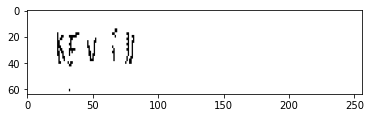

In [18]:
name_one_hot, name, img = test_ds[0]
print("Name in numbers:", name)
print("Name in characters: ", train_ds.convert_num_to_name(name.numpy()))
print("Name in one hot encoding:", name_one_hot)
show_example(img, train_ds.convert_num_to_name(name.numpy()))

#### Check one batch

In [19]:
def show_batch(dataloader):
    for name_one_hot, name, image in dataloader:
        print("Name:", [train_ds.convert_num_to_name(name.numpy()[k]) for k in range(len(name))])
        fig, ax = plt.subplots(figsize=(20,20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=2).permute(1,2,0))
        break

Name: ['BILEL#############################', 'LAUMIONIER########################', 'LEA###############################', 'JEAN-ROCH#########################', 'RUPP##############################', 'UNREADABLE########################', 'PICHON############################', 'DANIEL############################', 'JEREMY############################', 'JEAN-MICHEL#######################', 'JULIEN############################', 'NAEL##############################', 'BILGER############################', 'TIFFANY###########################', 'ELEEN#############################', 'ANTOINE###########################', 'AYOUB#############################', 'MINETTE###########################', 'RAINGEVAL#########################', 'CELESTIN##########################', 'DIBENEDETTO#######################', 'MATHIS############################', 'LOUNA#############################', 'SEVESTRE##########################', 'DAVANLAY##########################', 'HOCQUARD##########################', 'LEBR

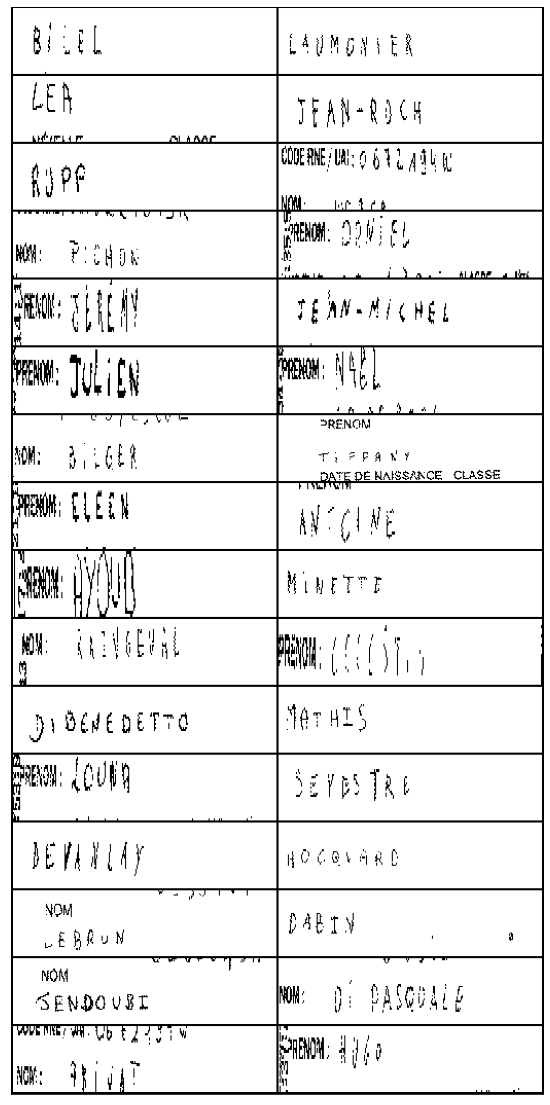

In [20]:
show_batch(dev_dl)

We see that some pictures have also written the word "prenom", "nom", etc. It would fine to delete these but there is no pattern we can follow.

### Implementation of the neural network

We use resnet18 as our model and fine tune the first and last layer

- We fine tune the first layer because resnet18 expect an image of input size 224x224
- We fine tune the last layer in order to have an output of size of len(train_ds.characters_to_num)*train_ds.max_name_length = 31 x 34 = 1054

In [21]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=len(train_ds.characters_to_num)*train_ds.max_name_length, bias=True)

Functions to use the GPU or CPU

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

#### Now we convert all the dataloaders and model to GPU or CPU

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
dev_dl = DeviceDataLoader(dev_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(model, device)

#### Summary of the model

In [25]:
summary(model, (1, 64, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 32, 128]           3,136
       BatchNorm2d-2          [-1, 64, 32, 128]             128
              ReLU-3          [-1, 64, 32, 128]               0
         MaxPool2d-4           [-1, 64, 16, 64]               0
            Conv2d-5           [-1, 64, 16, 64]          36,864
       BatchNorm2d-6           [-1, 64, 16, 64]             128
              ReLU-7           [-1, 64, 16, 64]               0
            Conv2d-8           [-1, 64, 16, 64]          36,864
       BatchNorm2d-9           [-1, 64, 16, 64]             128
             ReLU-10           [-1, 64, 16, 64]               0
       BasicBlock-11           [-1, 64, 16, 64]               0
           Conv2d-12           [-1, 64, 16, 64]          36,864
      BatchNorm2d-13           [-1, 64, 16, 64]             128
             ReLU-14           [-1, 64,

### Execution of the neural network

In [26]:
epochs = 10
max_lr = 1e-4
opt_func = torch.optim.Adam

In [27]:
@torch.no_grad()
def eval_model(model, val_loader):
    model.eval()
    torch.cuda.empty_cache()
    outputs = []
    loss_func = nn.MultiLabelSoftMarginLoss()
    for batch in tqdm(val_loader):
        name_one_hot, name, img = batch
        model_out = model(img)
        loss = loss_func(model_out, name_one_hot)
        outputs.append(loss.detach())
    return torch.stack(outputs).mean().item()

In [28]:
def train_model(epochs, max_lr, model, train_loader, dev_loader, test_loader, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr)
    loss_func = nn.MultiLabelSoftMarginLoss()
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        print("Starting epoch: ", epoch+1)
        for batch in tqdm(train_loader):
            name_one_hot, name, img = batch
            model_out = model(img)
            loss = loss_func(model_out, name_one_hot)
            
            train_losses.append(loss.detach())
            
            optimizer.zero_grad()
            
            loss.backward()
                
            optimizer.step()
    
        # Validation phase
        print("Saving model...")
        torch.save(model.state_dict(), './checkpoints/checkpoint'+str(epoch)+'.pth')
        result = {}
        print("Model saved")
        print("Evaluating development data")
        result['dev_loss'] = eval_model(model, dev_loader)
        print("Evaluating test data")
        result['test_loss'] = eval_model(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print("Adding results to the history")
        history.append(result)
        print("Train_loss: {} - dev_loss: {} - test_loss: {}".format(result['train_loss'], result['dev_loss'], result['test_loss']))
        
    return history

In [29]:
history = []

In [30]:
history += train_model(epochs, max_lr, model, train_dl, dev_dl, test_dl, opt_func)

Starting epoch:  1

Saving model...
Model saved
Evaluating development data

Evaluating test data

Adding results to the history
Train_loss: 0.01674637943506241 - dev_loss: 0.007834164425730705 - test_loss: 0.007870558649301529
Starting epoch:  2

Saving model...
Model saved
Evaluating development data

Evaluating test data

Adding results to the history
Train_loss: 0.006539111491292715 - dev_loss: 0.00538885360583663 - test_loss: 0.005414944142103195
Starting epoch:  3

Saving model...
Model saved
Evaluating development data

Evaluating test data

Adding results to the history
Train_loss: 0.004963484592735767 - dev_loss: 0.004728035535663366 - test_loss: 0.004755984991788864
Starting epoch:  4

Saving model...
Model saved
Evaluating development data

Evaluating test data

Adding results to the history
Train_loss: 0.004223657771945 - dev_loss: 0.004243419971317053 - test_loss: 0.004258438479155302
Starting epoch:  5

Saving model...
Model saved
Evaluating development data

Evaluating t

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    dev_losses = [x['dev_loss'] for x in history]
    test_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(dev_losses, '-rx')
    plt.plot(test_losses, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Development', "Test"])
    plt.title('Loss vs. No. of epochs')

#### Plot the loss of our model 

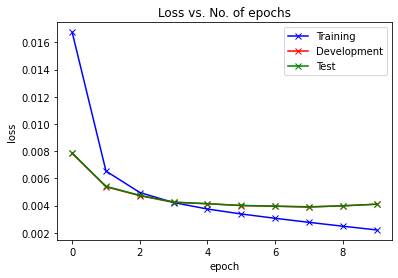

In [32]:
plot_losses(history)

### Validation

We validate our model calculating the accuracy in two different ways.

- Accuracy based in whether the predicted name match the expected one
- Accuracy based in the number of correctly matched characters compared to the expected ones.

The checkpoints can be downloaded from:

https://drive.google.com/drive/folders/1YASskEzWqvSY4rZ6RseGdR0zWGgbNl3j?usp=sharing

In [33]:
test_dl = DataLoader(test_ds, 1, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_dl = DeviceDataLoader(test_dl, device)

In [34]:
@torch.no_grad()
def test_model_accuracy(model, val_loader, checkpoint_name, epoch):
    model.eval()
    model.load_state_dict(torch.load(checkpoint_name))
    acc = 0
    acc2 = 0
    for batch in tqdm(val_loader):
        name_one_hot, name, img = batch
        pred = model(img)
        sq = pred.squeeze().cpu().tolist()
        out = []
        # Get the one hot encoding for each character an apply argmax in order to obtain 
        # the one that has bigger probability.
        for i in range(test_ds.max_name_length):
            out.append(np.argmax(sq[i*len(test_ds.characters_to_num):(i+1)*len(test_ds.characters_to_num)]))
        name_to_list = name.cpu().numpy()[0]
        # Calculate name accuracy
        if test_ds.convert_num_to_name(name_to_list) == test_ds.convert_num_to_name(out):
            acc += 1
        # Calculate character accuracy
        for num in range(len(name_to_list)):
            if name_to_list[num] == out[num]:
                acc2 += 1  
    print("Correctly matched names in epoch {} is: {}".format(str(epoch),str(acc/len(val_loader))))
    print("Correctly matched characters in epoch {} is: {}".format(str(epoch),str(acc2/(len(val_loader)*34))))
    return acc/len(val_loader), acc2/(len(val_loader)*34)

In [35]:
accuracy_history = []

In [36]:
for i in range(10):
    acc1, acc2 = test_model_accuracy(model, test_dl, "./checkpoints/checkpoint" + str(i) + ".pth", i)
    accuracy_history.append({"names":acc1, "chars":acc2})


Correctly matched names in epoch 0 is: 0.4517675544794189
Correctly matched characters in epoch 0 is: 0.9595399515738499

Correctly matched names in epoch 1 is: 0.6185956416464891
Correctly matched characters in epoch 1 is: 0.9737416322461188

Correctly matched names in epoch 2 is: 0.6685714285714286
Correctly matched characters in epoch 2 is: 0.9775737074490813

Correctly matched names in epoch 3 is: 0.7034866828087167
Correctly matched characters in epoch 3 is: 0.9800633812847173

Correctly matched names in epoch 4 is: 0.7139951573849879
Correctly matched characters in epoch 4 is: 0.9810233584959408

Correctly matched names in epoch 5 is: 0.725181598062954
Correctly matched characters in epoch 5 is: 0.9818636946303946

Correctly matched names in epoch 6 is: 0.7291767554479419
Correctly matched characters in epoch 6 is: 0.9822454066372311

Correctly matched names in epoch 7 is: 0.7360290556900726
Correctly matched characters in epoch 7 is: 0.9826321036889332

Correctly matched names 

In [37]:
def plot_accuracy(history):
    names = [x['names'] for x in history]
    chars = [x['chars'] for x in history]
    plt.plot(names, '-bx')
    plt.plot(chars, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Names', 'Characters'])
    plt.title('Accuracy for each epoch')

#### Checking the accuracy for each epoch

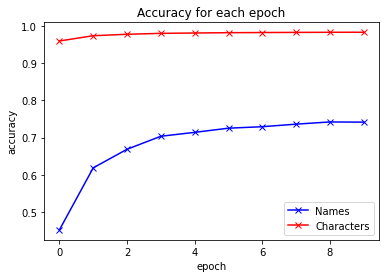

In [38]:
plot_accuracy(history)